In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.data import AUTOTUNE

2023-03-07 12:43:55.513320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = keras.models.load_model('neural_net')

img_height = 256
img_width = 256
image_dir = "images"
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    labels="inferred",
    class_names=["Austria","Australia"],
    subset="both",
    seed = 0,
    batch_size = batch_size,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width))

def standardize_image(image, label):
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    standardized_image = tf.map_fn(lambda x: (x - mean)/std, image)
    return (standardized_image, label)

train_ds =  train_ds.map(standardize_image)
val_ds = val_ds.map(standardize_image)


train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)


Found 25065 files belonging to 2 classes.
Using 20052 files for training.
Using 5013 files for validation.


In [3]:
def get_attributions(image, label, baseline, m):
    grads = np.zeros((m+1,256,256,3))
    for i in range(m+1):
        current_sample = baseline + (image - baseline)*i/m
        with tf.GradientTape() as g:
            g.watch(current_sample)
            predicted_label = model(current_sample)
            # loss = losses.BinaryCrossentropy(from_logits = False)(label, predicted_label)

            grads[i] = g.gradient(target = predicted_label, sources = current_sample)

    avg_grads = np.average((grads[:-1] + grads[1:]) / 2.0, axis = 0)
    return avg_grads*(image-baseline)

def rescale_image(image, new_min = 0, new_max = 1):
    image_min = np.min(image)
    image_max = np.max(image)
    if image_max - image_min > 0:
        image = (image*(new_max - new_min) + image_max*new_min - image_min*new_max)/(image_max - image_min)
    return image

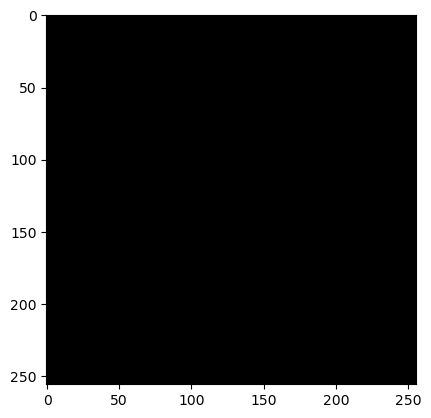

In [4]:
baseline = tf.zeros(shape = ((256,256,3)))
plt.imshow(baseline)
plt.show()

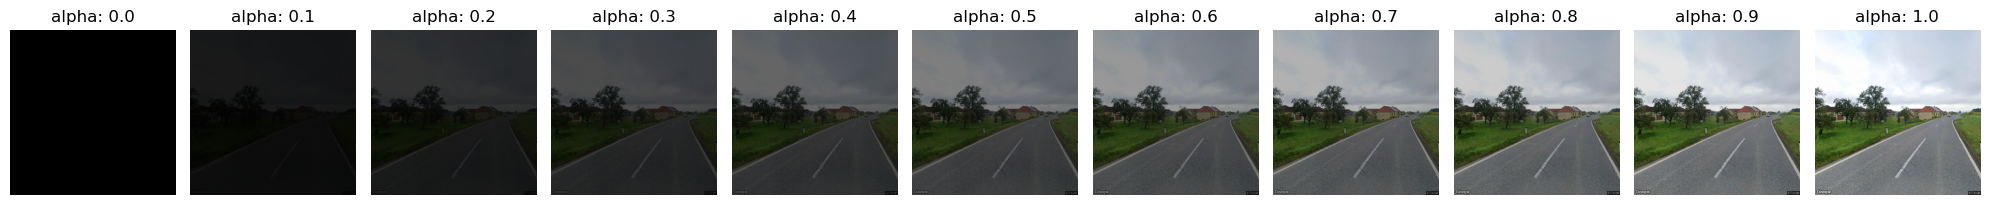

In [5]:
fig = plt.figure(figsize=(20, 20))

for images, labels in val_ds.take(1):
    image = images[0]
    image = rescale_image(image, 0, 1)
    for i, alpha in enumerate(np.linspace(0,1,11)):
      plt.subplot(1, 11, i + 1)
      plt.title(f'alpha: {alpha:.1f}')
      plt.imshow(alpha*image)
      plt.axis('off')

    plt.tight_layout();
plt.show()

Baseline prediction: 0.515879213809967
sum of attributions: -0.489276260137558
prediction - baseline_prediction: -0.5158713459968567
sum of attributions: -0.44848567247390747
prediction - baseline_prediction: -0.5157734751701355
sum of attributions: 0.446890264749527
prediction - baseline_prediction: 0.48408520221710205
sum of attributions: -0.4969186782836914
prediction - baseline_prediction: -0.5158771276473999
sum of attributions: -0.5176248550415039
prediction - baseline_prediction: -0.5158587694168091


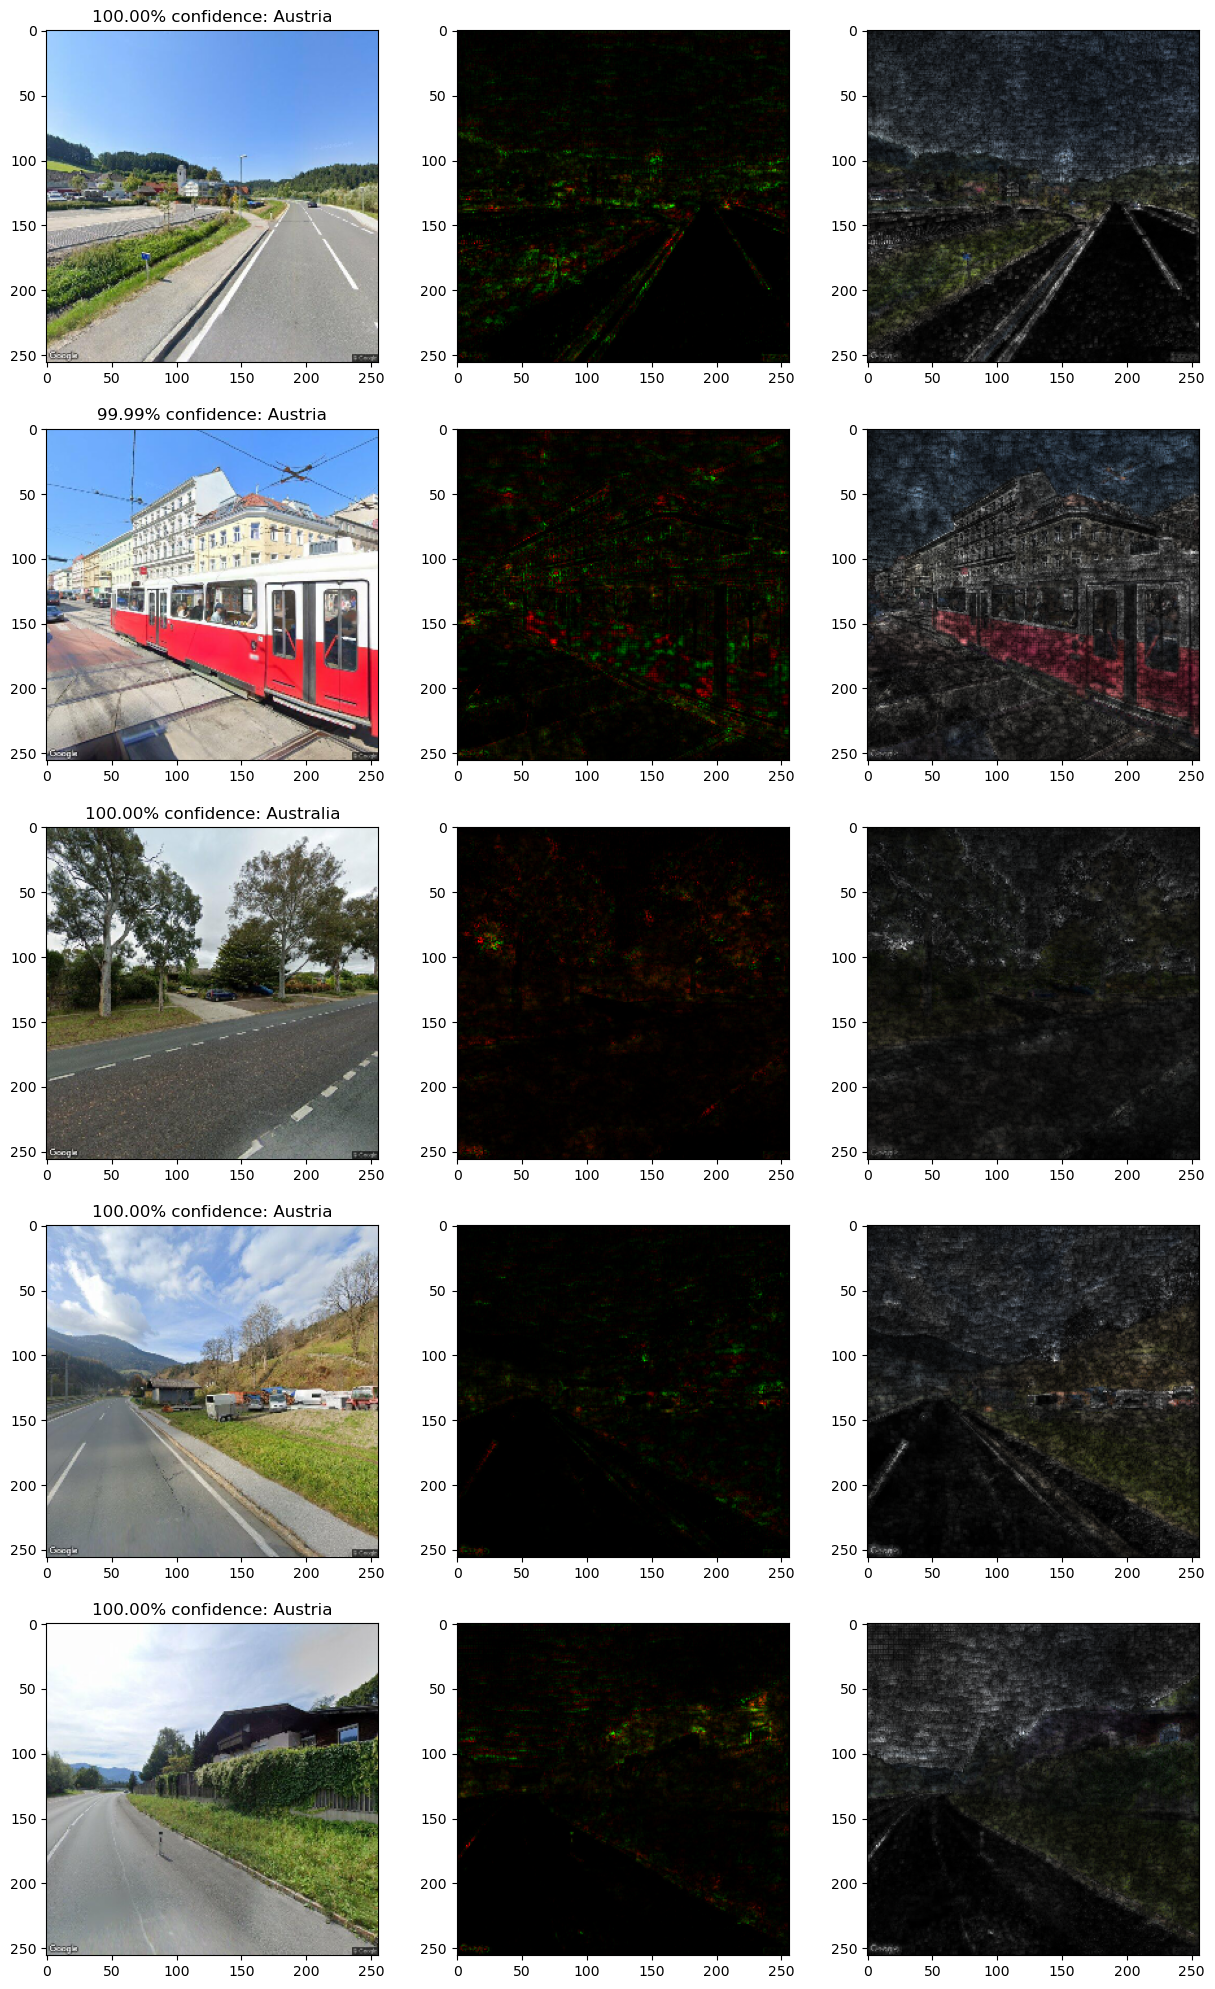

In [6]:
from visualization_lib import Visualize, pil_image, show_pil_image
num_images = 5
plt.figure(figsize= (15,5*num_images))

baseline_prediction = model(tf.expand_dims(baseline, axis = 0))
print(f"Baseline prediction: {baseline_prediction[0,0]}")
for images, labels in val_ds.take(1):
    keys = np.random.choice(len(images), num_images)
    
    for i in range(num_images):
        image = tf.reshape(images[keys[i]], (1,256,256,3))
        label = tf.reshape(labels[keys[i]], (1,1))
        prediction = model(image)[0,0]
        attributions = get_attributions(image, label, baseline, 100)[0]
        visual_attributions = Visualize(attributions, np.uint8(rescale_image(image,0,255)[0]), polarity = "both", overlay = False, morphological_cleanup=False)

        print(f"sum of attributions: {np.sum(attributions)}")
        print(f"prediction - baseline_prediction: {prediction - baseline_prediction[0,0]}")
        # baseline_loss = losses.BinaryCrossentropy(from_logits = False)(label, prediction)
        # prediction_loss = losses.BinaryCrossentropy(from_logits = False)(label, baseline_prediction)
        # print(f"{baseline_loss=}, {prediction_loss=}")
        
        plt.subplot(num_images,3,3*i+1)
        rescaled_image = rescale_image(image)
        plt.imshow(rescaled_image[0])
        if prediction > 0.5:
            plt.title(f"{100*prediction:.2f}% confidence: Australia")
        else:
            plt.title(f"{100*(1-prediction):.2f}% confidence: Austria")
        
        plt.subplot(num_images,3,3*i+2)
        plt.imshow(np.uint8(visual_attributions))
        
        plt.subplot(num_images,3,3*i+3)
        
        image = rescale_image(image,0,1)
        aggregated_attributions = np.average(tf.math.abs(attributions), axis=2)
        weighted_image = tf.repeat(tf.expand_dims(aggregated_attributions, axis = 2),3, axis = 2)*image
        plt.imshow(np.sqrt(rescale_image(weighted_image)[0]))
        
        